## Plotting the distribution of programming languages

In [1]:
from unidiff import PatchSet
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import json
from pandas import json_normalize
from tabulate import tabulate 
import glob
import time
from pathlib import Path
import re
import git
import sqlite3
from urllib.parse import urlparse
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
# load cve table from /Users/guru/research/FixMe/data/FixMe.db
conn = sqlite3.connect('/Users/guru/research/FixMe/data/FixMe-v1.db')
df_cve = pd.read_sql_query("SELECT * FROM cve;", conn)
df_repo = pd.read_sql_query("SELECT * FROM repository;", conn)
df_hunk = pd.read_sql_query("SELECT * FROM hunk_collection;", conn)
df_patch = pd.read_sql_query("SELECT * FROM patch_collection;", conn)

print(f'CVEs shape: {df_cve.shape}')
print(f'Commit shape: {df_repo.shape}')
print(f'Patches shape: {df_patch.shape}')
print(f'Hunks shape: {df_hunk.shape}')
print(f'Repos shape: {df_repo.shape}')
print(f'Total unique projects: {df_repo.repo.nunique()}')
print(f'CWEs shape: {df_cve.problemTypes.nunique()}')

CVEs shape: (17481, 73)
Commit shape: (1986, 5)
Patches shape: (18484, 10)
Hunks shape: (40405, 18)
Repos shape: (1986, 5)
Total unique projects: 811
CWEs shape: 587


In [32]:
import yaml
def load_config(config_path="generator/gen-config.yaml"):
    """ Load the configuration from the YAML file """
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

config = load_config()


# get the programming languages
pls = config['preprocess']['prog_lang']
pls = pls if isinstance(pls, list) else [pls]
pls

['C++']

# Scanning CVEs for git-based commit URLs

[10620  1159   279   229   217   199   188   174   171   162]


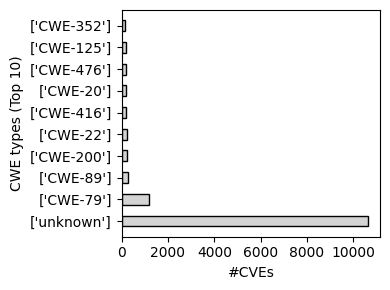

In [4]:
vals = df_cve.problemTypes.value_counts().head(10)
x = [str(x) for x in vals.index]
print(vals.values)

fig, ax = plt.subplots(figsize=(4, 3))
bar_width = 0.5
bars = ax.barh(x, width=vals.values,color='lightgray', edgecolor='black', height=bar_width)
ax.set_ylabel('CWE types (Top 10)')
ax.set_xlabel('#CVEs')
plt.tight_layout()
plt.savefig(f'figure/CWE-types.pdf', format='pdf')
plt.show()

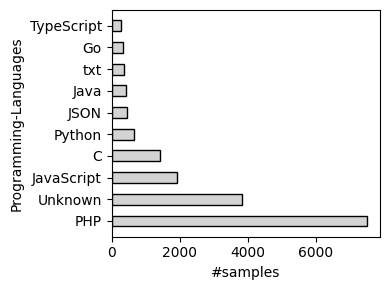

In [5]:
# plot_value_counts(col=df_patch['pl'], xlabel='Programming-Languages', ylabel='#patches')
pls = df_patch['programming_language'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(4, 3))
bar_width = 0.5
bars = ax.barh(pls.index, pls.values, color='lightgray', edgecolor='black', height=bar_width)
ax.set_ylabel('Programming-Languages')
ax.set_xlabel('#samples')
plt.tight_layout()
plt.savefig(f'figure/Programming-Languages.pdf', format='pdf')
plt.show()


Top 10 repositories with most CVEs referenced in their commits:


/var/folders/p_/9ryggq9s67zbhxhzlms6wmzw0000gn/T/ipykernel_10972/163870965.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('binary', 10)  # Using a grayscale colormap with 10 shades


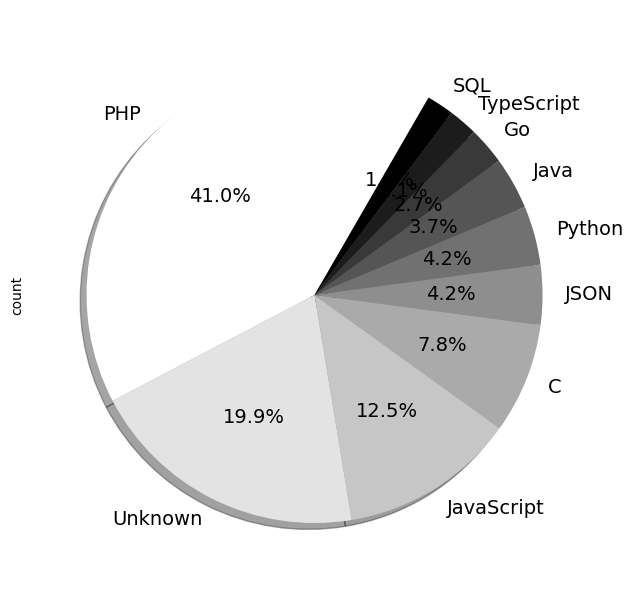

In [6]:
print('Top 10 repositories with most CVEs referenced in their commits:')
colors = cm.get_cmap('binary', 10)  # Using a grayscale colormap with 10 shades
pie_chart = df_hunk.programming_language.value_counts().head(10).plot.pie(
    autopct='%1.1f%%', fontsize=14, figsize=(8, 6), 
    legend=None, colors=[colors(i) for i in range(10)], 
    # edgecolor='black'
    startangle=60, 
    shadow=True
    )
plt.tight_layout()
plt.savefig('figure/top-10-pl.pdf', bbox_inches='tight', pad_inches=0.1, format='pdf', transparent=True, dpi=300)
plt.show()

Top 10 repositories with most CVEs referenced in their commits:


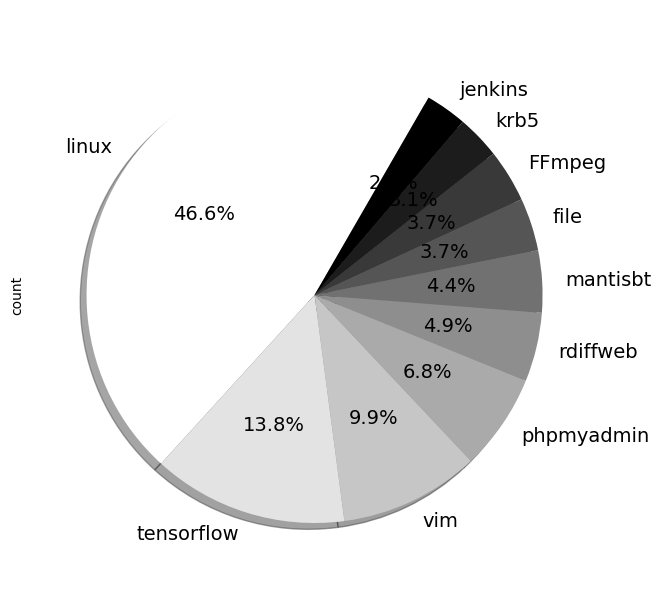

In [7]:
print('Top 10 repositories with most CVEs referenced in their commits:')
# pie_chart = df_repo.repo.value_counts().head(10).plot.pie(autopct='%1.1f%%',fontsize=11, figsize=(8, 6), legend=None)
df_count = df_repo.repo.value_counts().head(10).to_frame().reset_index()
df_count['repo'] = df_count.repo.apply(lambda x: '/'.join(x.split('/')[-2:]))
df_count['repo'] = df_count.repo.apply(lambda x: x.split('/')[-1])

pie_chart = df_count.plot.pie(
    autopct='%1.1f%%', fontsize=14, figsize=(8, 6), 
    y='count', labels=df_count['repo'],
    legend=None, 
    colors=[colors(i) for i in range(10)], 
    # edgecolor='black'
    startangle=60, 
    shadow=True
    )
plt.tight_layout()
plt.savefig('figure/top-10-repos.pdf',bbox_inches='tight', pad_inches=0.1)
plt.show()

# The function that counts the length of words in the values of a specified column in a DataFrame and plots the distribution as a histogram:

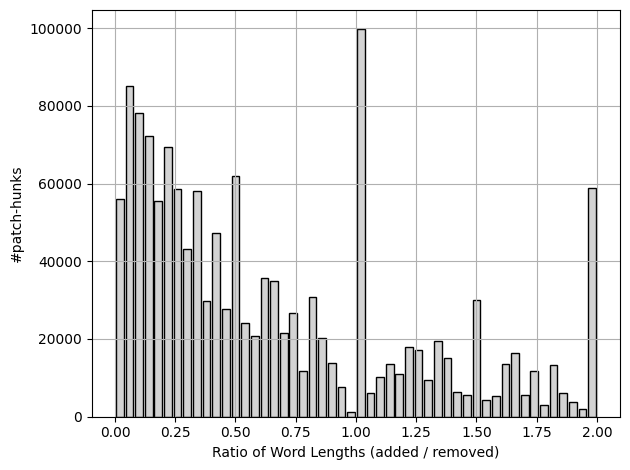

In [8]:
def count_and_plot_word_length_ratio(df, column1, column2):
    """
    Count the length of words in the values of two specified columns in a DataFrame,
    compute the ratio of corresponding word lengths, and plot the distribution as a histogram.
    """
    # Tokenize words and count lengths for both columns
    word_lengths1 = [len(word) for value in df[column1] for word in str(value).split()]
    word_lengths2 = [len(word) for value in df[column2] for word in str(value).split()]

    # Compute the ratio of word lengths
    word_length_ratio = [length2 / length1 if length1 != 0 else float('NaN') for length1, length2 in zip(word_lengths1, word_lengths2)]

    # Plot histogram
    plt.hist(word_length_ratio, bins=50, range=(0, 2), rwidth=0.8, color='lightgray', edgecolor='black')
    plt.xlabel('Ratio of Word Lengths (added / removed)')
    plt.ylabel('#patch-hunks')
    # plt.title('Distribution of Word Length Ratio (added / removed)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('figure/word-length-ratio.pdf', format='pdf')
    plt.show()
    return word_length_ratio

word_length_ratio = count_and_plot_word_length_ratio(df_hunk, 'removed_lines', 'added_lines')

Summary statistics for removed_lines
             #Words
count  38403.000000
mean      11.792725
std       15.823660
min        1.000000
25%        1.000000
50%        6.000000
75%       17.000000
max      103.000000
Summary statistics for added_lines
             #Words
count  38386.000000
mean      27.772209
std       47.413169
min        1.000000
25%        4.000000
50%       12.000000
75%       25.000000
max      316.000000


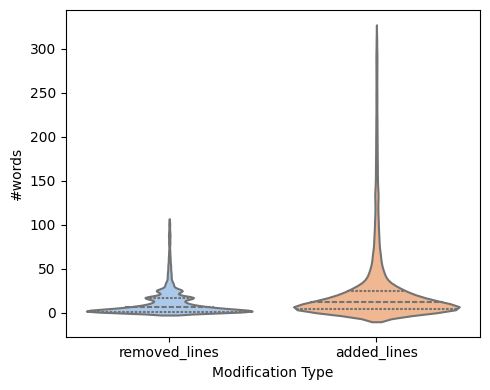

In [9]:
def count_and_plot_word_lengths(df, column1, column2, outlier_threshold=0.95):
    """
    Count the number of words in the values of two specified columns in a DataFrame
    and plot the distributions as violin plots side by side."""

    # Count number of words for both columns
    word_counts1 = [len(str(value).split()) for value in df[column1]]
    word_counts2 = [len(str(value).split()) for value in df[column2]]

    # Identify outliers using quantiles
    max_outlier_count1 = np.quantile(word_counts1, outlier_threshold)
    max_outlier_count2 = np.quantile(word_counts2, outlier_threshold)

    # Filter out outliers
    filtered_word_counts1 = [count for count in word_counts1 if count <= max_outlier_count1]
    filtered_word_counts2 = [count for count in word_counts2 if count <= max_outlier_count2]
    
    # Combine word counts from both columns without outliers
    combined_word_counts = {'Category': [column1]*len(filtered_word_counts1) + [column2]*len(filtered_word_counts2),
                            '#Words': filtered_word_counts1 + filtered_word_counts2}

    # Create DataFrame from combined data
    combined_df = pd.DataFrame(combined_word_counts)
    print(f'Summary statistics for {column1}')
    print(combined_df[combined_df['Category']==column1].describe())
    print(f'Summary statistics for {column2}')
    print(combined_df[combined_df['Category']==column2].describe())

    # Plot violin plot
    plt.figure(figsize=(5, 4))
    sns.violinplot(x='Category', y='#Words', data=combined_df, inner='quartile', hue='Category', palette='pastel', color='lightgray', linewidth=1.5, width=0.8)
    plt.xlabel('Modification Type')
    plt.ylabel('#words')
    plt.tight_layout()
    plt.savefig(f'figure/word-counts-violin.pdf', format='pdf')
    plt.show()

# Call the function with the DataFrame and column names
count_and_plot_word_lengths(df_hunk, 'removed_lines', 'added_lines')

# Plotting of original CVEs and those included FixMe

In [10]:
def find_json_files(directory):
    """Find all JSON files in the given directory (including subdirectories)."""
    json_files = glob.glob(os.path.join(
        directory, "**/*.json"), recursive=True)
    json_files = [Path(x).stem for x in json_files]
    return [x for x in json_files if 'cve' in x.lower()]

total_cves= find_json_files('/Users/guru/research/FixMe/data/cvelistV5/cves')
print(f"Total CVEs: {len(total_cves)}")
ref_cves = df_cve.cveId.tolist()
print(f"Total CVEs in DB: {len(ref_cves)}")
print(f'propotion of CVEs in DB: {len(ref_cves)/len(total_cves) * 100:.2f}%')

Total CVEs: 242022
Total CVEs in DB: 17481
propotion of CVEs in DB: 7.22%


In [11]:
years_cve_total = [file.split('-')[1] for file in total_cves]
years_cve_ref = [file.split('-')[1] for file in ref_cves]

freq_total = pd.Series(years_cve_total).value_counts().sort_index()
freq_ref = pd.Series(years_cve_ref).value_counts().sort_index()
# Get unique years from both Series
all_years = sorted(set(freq_total.index) | set(freq_ref.index))

# Reindex both Series with all years and fill NaN (missing values) with 0
freq_total= freq_total.reindex(all_years, fill_value=0)
freq_ref = freq_ref.reindex(all_years, fill_value=0)

/var/folders/p_/9ryggq9s67zbhxhzlms6wmzw0000gn/T/ipykernel_10972/2011892101.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(index, p(index), "r--", color='red', label="Trend line")


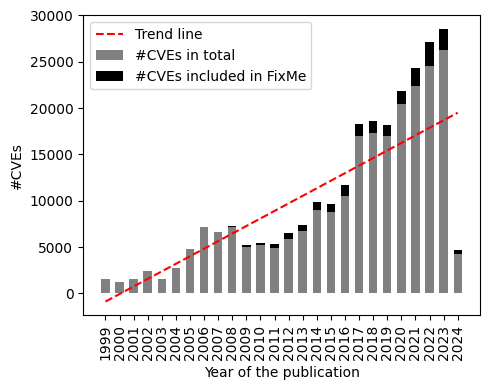

In [12]:
# Your existing code for plotting the bar chart...
fig, ax = plt.subplots(figsize=(5, 4))
bar_width = 0.6
index = range(len(freq_total))

bar1 = ax.bar(freq_total.index, freq_total.values, bar_width, label='#CVEs in total', color='gray')
bar2 = ax.bar(freq_ref.index, freq_ref.values, bar_width, label='#CVEs included in FixMe', bottom=freq_total.values, color='black')

# Fit a polynomial (linear trend line in this case)
z = np.polyfit(index, freq_total.values, 1)
p = np.poly1d(z)

# Plot the trend line
ax.plot(index, p(index), "r--", color='red', label="Trend line")

# Adding labels, title, and legend
ax.set_xlabel('Year of the publication')
ax.set_ylabel('#CVEs')
ax.set_xticks(index)
ax.set_xticklabels(freq_total.index, rotation=90)
ax.legend()
plt.tight_layout()
plt.savefig('figure/cve_yearly_bar.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [13]:
# Fit a polynomial (linear trend line in this case)
z = np.polyfit(index, freq_total.values, 1)
# Slope of the trend line (increasing rate)
increasing_rate = z[0]
print("Increasing rate of the trend line:", increasing_rate)

# Summing up the total number of CVEs and CVEs in FixMe
total_cves_count = sum(freq_total)
cves_in_fixme_count = sum(freq_ref)

# Calculating the percentage
percentage_in_fixme = (cves_in_fixme_count / total_cves_count) * 100
print(f"The percentage of total CVEs included in FixMe is: {percentage_in_fixme:.2f}%")


Increasing rate of the trend line: 815.6984615384615
The percentage of total CVEs included in FixMe is: 7.22%


## Alternatively

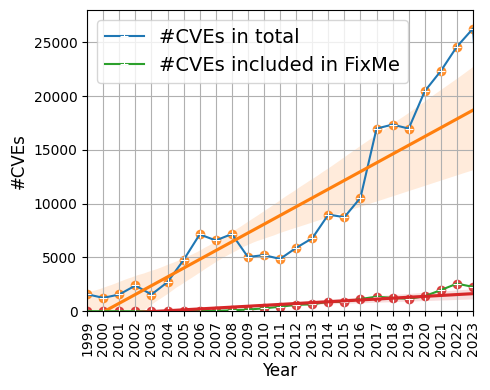

In [14]:
df = pd.DataFrame({'year': freq_total.index.astype(int), 'count': freq_total.values.astype(int)})
df['count2'] = freq_ref.values.astype(int)

df.index = df['year']
df.rename(columns={'count': '#CVEs in total', 'count2': '#CVEs included in FixMe'}, inplace=True)

plt.figure(figsize=(5, 4))

for column in df.columns:
    if column != 'year':
        sns.lineplot(x=df.index, y=df[column], marker='+', linestyle='-', label=column)
        # sns.barplot(x=df.index, y=df[column], alpha=0.2, label=column)
        sns.regplot(x=df.index, y=df[column], scatter=True)

plt.xlabel('Year', fontsize=12)
plt.ylabel('#CVEs', fontsize=12)
# plt.title('Trend of CVEs Each Year')
plt.xticks(df.year, rotation=90)  
plt.xlim(1999, 2023)  
plt.ylim(0, 28000)
plt.grid() 
plt.legend(loc='upper left', fontsize=14)  
plt.tight_layout()
plt.savefig('figure/cve_yearly_line.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Retrieve vul-fix pairs (patch hunks) for C programming language 

In [15]:
df_c = df_hunk[df_hunk.programming_language=='C'][['code_before', 'code_after']].reset_index(drop=True)
df_c.head()

,code_before,code_after
0,\telse\n\t\tci->hcd = hcd;\n\n\treturn ret;\n}...,\telse\n\t\tci->hcd = hcd;\n\n\tif (ci->platda...
1,\thdr->sadb_msg_version = PF_KEY_V2;\n\thdr->s...,\thdr->sadb_msg_version = PF_KEY_V2;\n\thdr->s...
2,\thdr->sadb_msg_errno = (uint8_t) 0;\n\thdr->s...,\thdr->sadb_msg_errno = (uint8_t) 0;\n\thdr->s...
3,};\n\nstatic struct extra_reg intel_snb_extra_...,};\n\nstatic struct extra_reg intel_snb_extra_...
4,\t\tx86_pmu.event_constraints = intel_snb_even...,\t\tx86_pmu.event_constraints = intel_snb_even...


# Further processing of the code snippets

<Axes: ylabel='Frequency'>

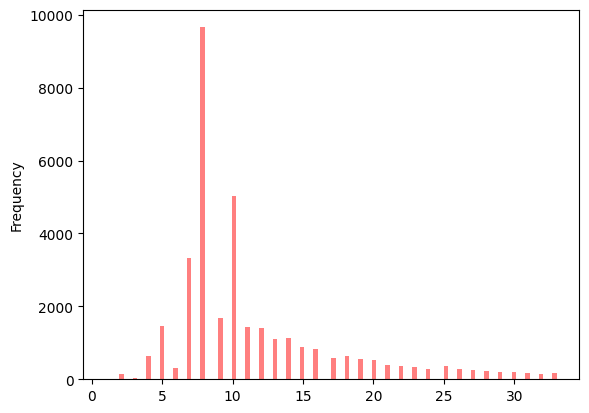

In [16]:
# Assuming you have a pandas DataFrame called df_hunk with a column named 'hunk_length'

def remove_outliers(df, column_name):
    """
    Removes outliers from a DataFrame column using the interquartile range (IQR) method.
    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): Name of the column containing the data to filter.
    
    Returns:
        pd.DataFrame: A new DataFrame with outliers removed.
    """
    df[column_name] = df[column_name].astype(int)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]


df_filtered = remove_outliers(df_hunk, 'hunk_length')
df_filtered['hunk_length'].astype(int).plot(kind='hist', bins=100, alpha=0.5, color='r', label='hunk_length')
